<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/21_TransferLearningwithTF/Transfer_Learning_and_Fine_Tuning_on_Flower_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary libraries

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

# Download the flower dataset from TensorFlow Datasets

In [48]:
import tensorflow_datasets as tfds

# Load the dataset

In [49]:
dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)

# Split the dataset into training, validation, and test sets

In [50]:
train_dataset = dataset['train'].take(3000)  # First 300 samples for training
validation_dataset = dataset['train'].skip(3000).take(200)  # Next 50 for validation
test_dataset = dataset['train'].skip(3200).take(200)  # Last 50 for testing

In [51]:
# Get one batch of images and labels
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (333, 500, 3)
Label batch shape: ()


# Preprocessing the dataset (resize and batch)

In [52]:
BATCH_SIZE = 64
IMG_SIZE = (160, 160)

def format_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train_dataset = train_dataset.map(format_image).batch(BATCH_SIZE).shuffle(100)
validation_dataset = validation_dataset.map(format_image).batch(BATCH_SIZE)
test_dataset = test_dataset.map(format_image).batch(BATCH_SIZE)

# Display first few images and labels


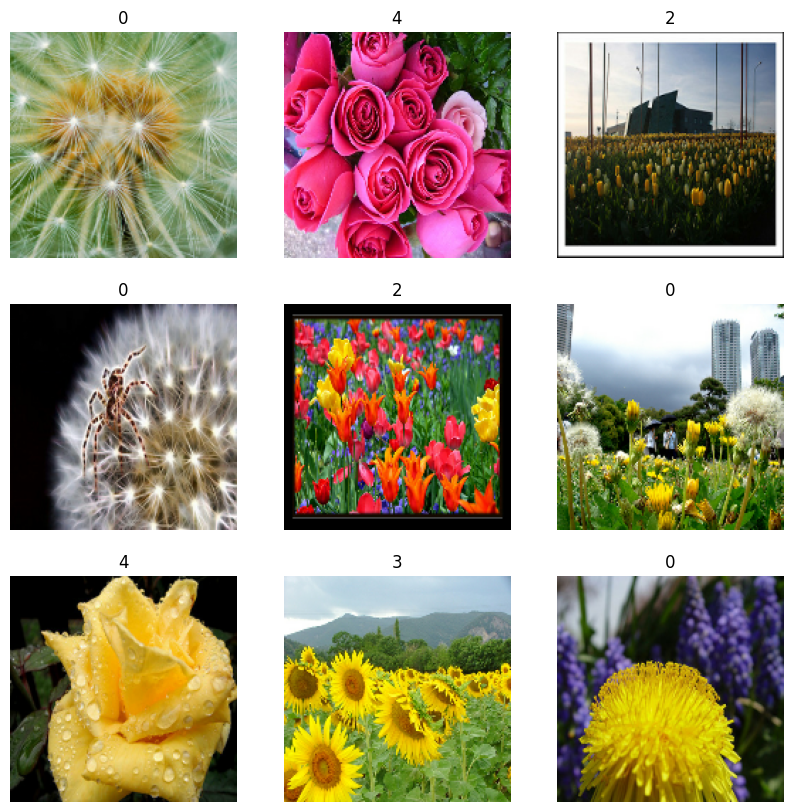

In [53]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(int(labels[i]))  # Labels are in numerical format
        plt.axis("off")

# Load pre-trained MobileNetV2 model, excluding the top layers (use as a feature extractor)


In [54]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')

In [55]:
# Freeze the base model (do not train its weights initially)
base_model.trainable = False

# data augmentation layers

In [56]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.3),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.3),
    tf.keras.layers.RandomWidth(0.2),   # Additional augmentations
    tf.keras.layers.RandomHeight(0.2)
])

# Add a new classification head on top of the frozen base model

In [57]:
from tensorflow.keras import regularizers

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)  # Preprocess input
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)  # feature extraction
x = tf.keras.layers.GlobalAveragePooling2D()(x)  # to reduce data size (spatial dimensions) while retaining important features.
x = tf.keras.layers.Dropout(0.3)(x)  # Dropout for regularization
outputs = tf.keras.layers.Dense(5)(x)  # 5 output units for the flower categories
x = tf.keras.layers.Dense(5, kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

In [58]:
model = tf.keras.Model(inputs, outputs)

# Compile the model

In [59]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model for a few epochs


In [60]:
initial_epochs = 10
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 567ms/step - accuracy: 0.2373 - loss: 1.7420 - val_accuracy: 0.1900 - val_loss: 1.6565
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 436ms/step - accuracy: 0.1925 - loss: 1.7414 - val_accuracy: 0.1900 - val_loss: 1.6620
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 397ms/step - accuracy: 0.2108 - loss: 1.6971 - val_accuracy: 0.1900 - val_loss: 1.6538
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 317ms/step - accuracy: 0.2220 - loss: 1.7250 - val_accuracy: 0.1900 - val_loss: 1.6476
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 387ms/step - accuracy: 0.2064 - loss: 1.7143 - val_accuracy: 0.1900 - val_loss: 1.6418
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 308ms/step - accuracy: 0.2058 - loss: 1.6929 - val_accuracy: 0.1900 - val_loss: 1.6486
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 296ms/step - accuracy: 0.2268 - loss: 1.6852 - val_accuracy: 0.1900 - val_loss: 1.6424
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 18s 317ms/step - accuracy: 0.2030 - loss: 1.7027 - val_accu

# Plot the learning curves

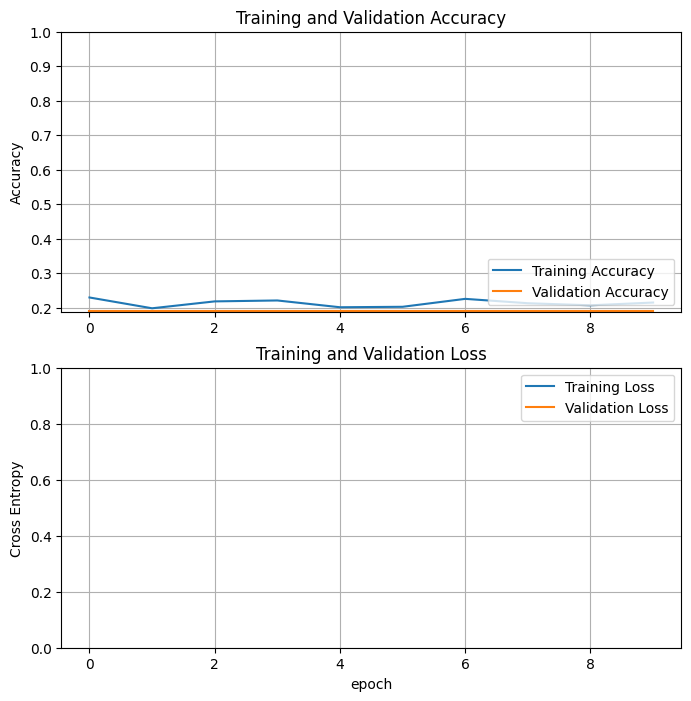

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()

plt.show()

# fine-tuning

In [62]:
base_model.trainable = True   # Unfreeze the top layers

In [63]:
# freeze all layers except the last few
fine_tune_at = 50  # Unfreeze from this layer onwards

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [64]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Fine-tune the model

In [65]:
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs
class_weights = {0: 1.0, 1: 0.5, 2: 2.0, 3: 1.0, 4: 1.5}  # Adjust based on class distribution
model.fit(train_dataset, epochs=total_epochs, class_weight=class_weights, validation_data=validation_dataset)

Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 49s 532ms/step - accuracy: 0.1832 - loss: 2.3186 - val_accuracy: 0.1900 - val_loss: 1.6417
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - accuracy: 0.2096 - loss: 2.2184 - val_accuracy: 0.1900 - val_loss: 1.6467
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 328ms/step - accuracy: 0.2009 - loss: 2.1192 - val_accuracy: 0.1900 - val_loss: 1.6519
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 301ms/step - accuracy: 0.2260 - loss: 2.0510 - val_accuracy: 0.1900 - val_loss: 1.6580
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 315ms/step - accuracy: 0.2085 - loss: 2.0273 - val_accuracy: 0.1900 - val_loss: 1.6725
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 282ms/step - accuracy: 0.2285 - loss: 1.9629 - val_accuracy: 0.1900 - val_loss: 1.6901
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 300ms/step - accuracy: 0.2123 - loss: 2.0260 - val_accuracy: 0.1900 - val_loss: 1.6954
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - accuracy: 0.2141 - loss: 2.0028 - val_accu

# Plot learning curves for fine-tuning

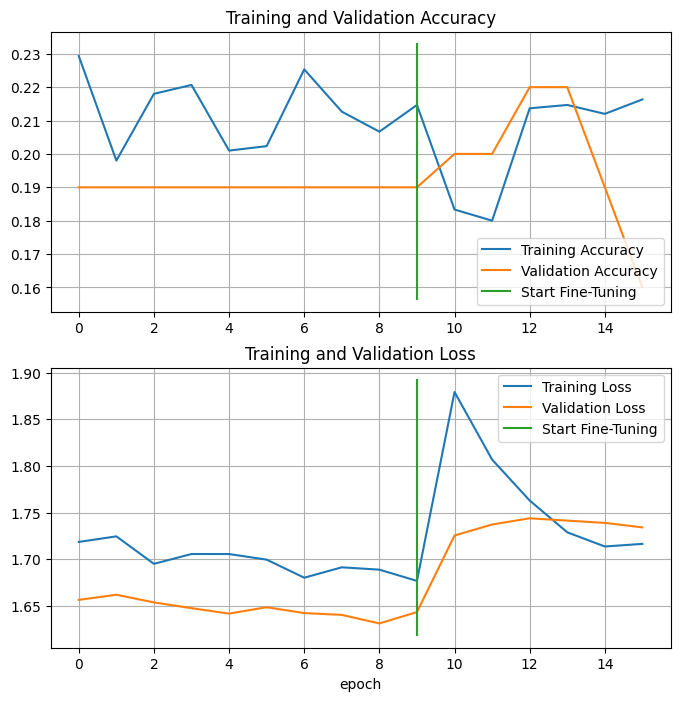

In [66]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine-Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.grid()

plt.show()


# Evaluate the model

In [67]:
from sklearn.metrics import classification_report
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        39
           2       0.00      0.00      0.00        41
           3       0.00      0.00      0.00        36
           4       0.22      1.00      0.36        44

    accuracy                           0.22       200
   macro avg       0.04      0.20      0.07       200
weighted avg       0.05      0.22      0.08       200



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predictions on a batch of test images


In [68]:
image_batch, label_batch = next(iter(test_dataset))
predictions = model.predict(image_batch)
predicted_labels = np.argmax(predictions, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


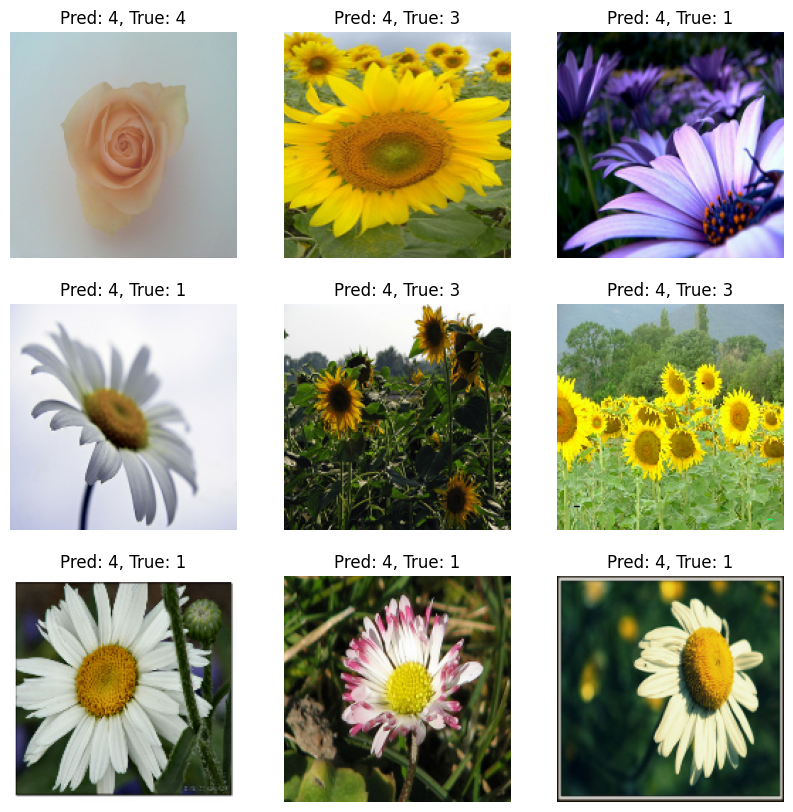

In [69]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy())
    plt.title(f"Pred: {predicted_labels[i]}, True: {label_batch[i]}")
    plt.axis("off")